In [1]:
import requests
import json
import pprint as pprint
import prettytable
import pandas as pd
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unicodedata import normalize
import time

In [2]:

#Get data for Modeled Wage Estimate (MWE) from BLS.gov. Limitation: Most recent data is 2019.
#The essential output is producing a list of cities per the base GEO dataset
#of the MWE in $/hr based on a user's choice of occupation, ensuring each city has something for output.
#The series names encode several qualifying properties, such as location and occupation, which
#are not displayed at the url and must be decoded for use.
url = "https://download.bls.gov/pub/time.series/wm/wm.data.1.AllData"
response = requests.get(url).text
no_r_list = response.split('\r\n')
no_t_list = [row.split('\t') for row in no_r_list]
column_head = [item.strip() for item in no_t_list[0]]
row_list = no_t_list[1::]
df_dic = {}
for column in range(len(column_head)-1): 
        df_dic[column_head[column]]= [row_list[row][column] for row in range(len(row_list)-1)]

BLS_MWE_df = pd.DataFrame(df_dic)
BLS_MWE_df = BLS_MWE_df.rename(columns={"value": "MWE"})


In [3]:

# Build dictionary (and reverse dictionary) based on the lookup tables from the urls.
url_dic = {}
url_dic = {"MWE_Location": "https://download.bls.gov/pub/time.series/wm/wm.area",
           "MWE_Occupation Type": "https://download.bls.gov/pub/time.series/wm/wm.occupation",
           "MWE_Skill Level": "https://download.bls.gov/pub/time.series/wm/wm.level",
           "MWE_How Paid": "https://download.bls.gov/pub/time.series/wm/wm.subcell"}
series_dic={}
inv_series_dic={}
for key in url_dic:
        time.sleep(0.25)
        response = requests.get(url_dic[key]).text
        no_r_list = response.split('\r\n')
        no_t_list = [row.split('\t') for row in no_r_list]
        no_t_list[0][0]
        dictionary={no_t_list[i][0]: no_t_list[i][1] for i in range(len(no_t_list)-1)}
        inv_dictionary={no_t_list[i][1]: no_t_list[i][0] for i in range(len(no_t_list)-1)}
        series_dic[key] = dictionary
        inv_series_dic[key] = inv_dictionary

# Identify where in the series_id string the codes for the above are.
BLS_MWE_Series_String_dic = {"MWE_Location": [3,10],
                             "MWE_Occupation Type": [19,25], 
                             "MWE_Skill Level": [27,29],
                             "MWE_How Paid": [25,27]}


In [21]:
# This code helps validate the creation of the dictionaries. 
# testseries = "WMU00356201020000001500002500"

# for dic_field in list(series_dic.keys()):
#     print(str(dic_field)+" for testseries is:"+ series_dic[dic_field] \
#            [testseries[BLS_MWE_Series_String_dic[dic_field][0]:BLS_MWE_Series_String_dic[dic_field][1]]])

MWE_Location for testseries is:New York-Newark-Jersey City, NY-NJ-PA
MWE_Occupation Type for testseries is:Computer and mathematical occupations
MWE_Skill Level for testseries is:All levels
MWE_How Paid for testseries is:Full-time


In [4]:

# Create a dictionary to match GEO city identifiers with BLS city identifiers. 
# Dictionary should input the GEO data, pass through BLS data, and return the Location codes that are part of 
# querying BLS Series.

GeoID_2_BLS_Locations_df = pd.read_csv("../data/GeoIDs - City.csv")
GeoID_2_BLS_Locations_df["city, state"] = GeoID_2_BLS_Locations_df["cityname"] + ", " + GeoID_2_BLS_Locations_df["stateabbrev"]


GEO_to_BLS_Location_dic={}
GEO_to_BLS_citynotfound_list=[]
GEO_to_BLS_howtranslated = {}
i=0

for citystate in GeoID_2_BLS_Locations_df["city, state"]:
    GEO_citystate = GeoID_2_BLS_Locations_df[GeoID_2_BLS_Locations_df["city, state"]==citystate]["city, state"].tolist()[0]
    GEO_city = GeoID_2_BLS_Locations_df[GeoID_2_BLS_Locations_df["city, state"]==citystate]["cityname"].tolist()[0]
    GEO_state_full = GeoID_2_BLS_Locations_df[GeoID_2_BLS_Locations_df["city, state"]==citystate]["statename"].tolist()[0]
    GEO_state_abbrev = GeoID_2_BLS_Locations_df[GeoID_2_BLS_Locations_df["city, state"]==citystate]["stateabbrev"].tolist()[0]
    try:    
        inv_series_dic['MWE_Location'][GEO_citystate]
        GEO_to_BLS_Location_dic[citystate] = GEO_citystate
        GEO_to_BLS_howtranslated[citystate] = "directly"
    except:
        try:
            GEO_to_BLS_Location_dic[citystate] = [key for key in list(inv_series_dic['MWE_Location'].keys()) \
                if GEO_city in key \
                if GEO_state_abbrev in key[key.find(",")::]][0]
            GEO_to_BLS_howtranslated[citystate] = "best match"
        except:
            try: 
                inv_series_dic['MWE_Location'][GEO_state_full][0]
                GEO_to_BLS_Location_dic[citystate] = GEO_state_full
                GEO_to_BLS_howtranslated[citystate] = "state only"
            except: 
                GEO_to_BLS_Location_dic[citystate] = float("NaN")
                i=i+1
                GEO_to_BLS_citynotfound_list.append(citystate)
                print(f"WARNING: {i} cities not found: {GEO_to_BLS_citynotfound_list}")

GEO_to_BLS_Location_Code_Lookup={key:inv_series_dic['MWE_Location'][value]\
                                for (key,value) in GEO_to_BLS_Location_dic.items()}
inv_GEO_to_BLS_Location_Code_Lookup = {inv_series_dic['MWE_Location'][value]:key\
                                for (key,value) in GEO_to_BLS_Location_dic.items()}

In [5]:
# Add relevant columns to the overall dataframe. Check that all cities from GEO dataset were mapped to cities in BLS. 

print("Dataframe Augmented Columns for keys and values for:")
for dic_field in list(url_dic.keys()):
    print(dic_field)
    BLS_MWE_df[dic_field] = [series_dic[dic_field][series[BLS_MWE_Series_String_dic[dic_field][0]:\
                                                              BLS_MWE_Series_String_dic[dic_field][1]]] \
                            for series in BLS_MWE_df["series_id"].tolist()]
    BLS_MWE_df[dic_field+"_code"] = [series[BLS_MWE_Series_String_dic[dic_field][0]:\
                                                              BLS_MWE_Series_String_dic[dic_field][1]] \
                            for series in BLS_MWE_df["series_id"].tolist()]
GEO_citystate =[]
print("GEO_city,state")
for series in BLS_MWE_df["series_id"].tolist(): 
    try:
        GEO_citystate.append(inv_GEO_to_BLS_Location_Code_Lookup[series[BLS_MWE_Series_String_dic["MWE_Location"][0]:\
                                                                    BLS_MWE_Series_String_dic["MWE_Location"][1]]])
    except:
        GEO_citystate.append(float("NaN"))
BLS_MWE_df["GEO_city,state"] = GEO_citystate
print("End of List.")
# remove any values that could not be matched to GEO Cities.
BLS_MWE_df_clean = BLS_MWE_df.dropna(how = "any")
# Confirm resultant dataframe has as many city/states as original dataframe.
print(f"Matched {len(GeoID_2_BLS_Locations_df.index)} cities from GEO to {BLS_MWE_df_clean['GEO_city,state'].nunique()} cities from BLS.")

Dataframe Augmented Columns for keys and values for:
MWE_Location
MWE_Occupation Type
MWE_Skill Level
MWE_How Paid
GEO_city,state
End of List.
Matched 53 cities from GEO to 51 cities from BLS.


In [6]:
# Check for any leftover cities, see if BLS lumps them in with cities already processed.
for city in GeoID_2_BLS_Locations_df["city, state"].tolist():
    if city not in BLS_MWE_df_clean['GEO_city,state'].unique().tolist():
        try:
            city_temp = GEO_to_BLS_Location_Code_Lookup[city]
            temp_df = BLS_MWE_df[BLS_MWE_df["MWE_Location_code"]==city_temp].reset_index(drop=True) 
            temp_df["GEO_city,state"] = [city for i in range(len(temp_df["GEO_city,state"]))]
            BLS_MWE_df_clean = BLS_MWE_df_clean.append(temp_df)
            BLS_MWE_df_clean=BLS_MWE_df_clean.reset_index(drop=True)
        except:
            print(f"{city} could not be added.")
print(f"Matched {len(GeoID_2_BLS_Locations_df.index)} cities from GEO to {BLS_MWE_df_clean['GEO_city,state'].nunique()} cities from BLS.")

Matched 53 cities from GEO to 53 cities from BLS.


Count of 53 required to provide info for all cities. Code developed to fill in blanks by loosening series parameters for how paid and level.


<ipython-input-26-26e6c1bd5ff9>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


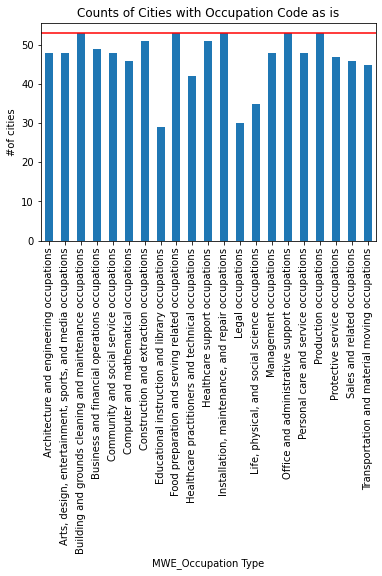

In [26]:
#Identifies need for further data cleanup with BLS_MWE_GEO_DF_Occupation_Builder()

#Bar Chart shows that there are cities with no data for the given 
# occupation with how paid = full time and level = all levels.
BLS_Occupation = [key for key in list(series_dic["MWE_Occupation Type"].keys()) if "000"in key]
BLS_MWE_df_citycount=BLS_MWE_df_clean[BLS_MWE_df_clean["MWE_Occupation Type_code"].isin(BLS_Occupation)]
BLS_MWE_df_citycount = BLS_MWE_df_citycount[(BLS_MWE_df_citycount["MWE_Skill Level_code"]=="00") \
                                            &(BLS_MWE_df_citycount["MWE_How Paid_code"]=="25")]
BLS_MWE_df_citycount=BLS_MWE_df_citycount.groupby("MWE_Occupation Type")["GEO_city,state"].count()
BLS_MWE_df_citycount

BLS_MWE_df_citycount.plot.bar(title="Counts of Cities with Occupation Code as is",ylabel="#of cities")
plt.axhline(y=53, color='r', linestyle='-')
print("Count of 53 required to provide info for all cities. Code developed to fill in blanks by loosening series parameters for how paid and level.")
plt.savefig("bar_pre_clean.png", bbox_inches = "tight")

In [11]:

# Adds cities to occupations by loosening occupation how_paid and skill level parameters.
BLS_Occupation = [key for key in list(series_dic["MWE_Occupation Type"].keys()) if "000"in key]

BLS_MWE_ALL_OCC_df = pd.DataFrame(columns = BLS_MWE_df_clean.columns.tolist())
for Occupation in BLS_Occupation:
    BLS_MWE_df_choice = BLS_MWE_df_clean[(BLS_MWE_df_clean["MWE_Occupation Type_code"]==Occupation) \
            &(BLS_MWE_df_clean["MWE_Skill Level_code"]=="00") \
            &(BLS_MWE_df_clean["MWE_How Paid_code"]=="25")]
    city_wo_occ = [y for y in GeoID_2_BLS_Locations_df["city, state"].tolist() \
                   if y not in BLS_MWE_df_choice["GEO_city,state"].tolist() ]
    for city in city_wo_occ:
        try:
            BLS_MWE_df_choice = BLS_MWE_df_choice.\
            append(BLS_MWE_df_clean[(BLS_MWE_df_clean["MWE_Occupation Type_code"]==Occupation)&\
                    (BLS_MWE_df_clean["GEO_city,state"]==city)].iloc[[0]])
        except:
            temp_dic={}
            for key in BLS_MWE_df_choice.columns:
                temp_dic[key]=["Not Found"] 
                temp_dic["GEO_city,state"] = city
                temp_dic["MWE_Occupation Type_code"] = Occupation
                temp_dic["MWE_Occupation Type"] = series_dic["MWE_Occupation Type"][Occupation]
            new_row = pd.DataFrame(data=temp_dic)
            BLS_MWE_df_choice = BLS_MWE_df_choice.append(new_row).reset_index(drop=True)
    BLS_MWE_ALL_OCC_df = BLS_MWE_ALL_OCC_df.append(BLS_MWE_df_choice)
BLS_MWE_ALL_OCC_df = BLS_MWE_ALL_OCC_df.reset_index(drop=True)


Code vastly improves the number of cities with displayable options for each occupation type.


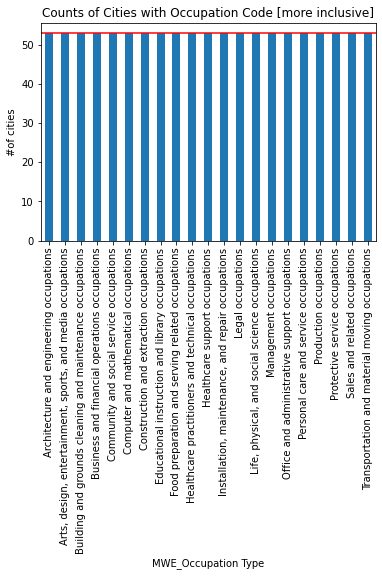

In [27]:
# Shows that BLS_MWE_GEO_DF_Occupation_Builder() is effective.
# Display a bar chart to confirm efforts have all cities as options for all occupations.
test_df_bar =BLS_MWE_ALL_OCC_df.groupby("MWE_Occupation Type")["GEO_city,state"].count()
test_df_bar.plot.bar(title="Counts of Cities with Occupation Code [more inclusive]",ylabel="#of cities")
plt.axhline(y=53, color='r', linestyle='-')
print("Code vastly improves the number of cities with displayable options for each occupation type.")
plt.savefig("bar_POST_clean.png", bbox_inches = "tight")

In [13]:
# Ready to fully merege with the GEO city data.

# Rename the columns so there is something merge on.
GeoID_2_BLS_Locations_rename_df=GeoID_2_BLS_Locations_df.rename(columns = {"city, state":"GEO_city,state"})

# Merge the dfs.
BLS_GEO_OCCUPATION_ALL_df_merge = BLS_MWE_ALL_OCC_df.\
    merge(GeoID_2_BLS_Locations_rename_df, how="outer",on="GEO_city,state")

BLS_GEO_OCCUPATION_ALL_df_merge = BLS_GEO_OCCUPATION_ALL_df_merge[["GEO_city,state","year","MWE",\
                                                                   "MWE_Occupation Type_code",\
                                                                   "MWE_Occupation Type","MWE_Skill Level",\
                                                                   "MWE_How Paid",'cityid','cityname',\
                                                                   'stateabbrev','statename','statefips','lat',\
                                                                   'lon','city_pop2019']]
# write to csv.
BLS_GEO_OCCUPATION_ALL_df_merge.to_csv('../output_files/BLS_GEO_OCCUPATION_ALL_df_merge.csv')

# display in notebook as well.
BLS_GEO_OCCUPATION_ALL_df_merge

GEO_city,state  year    MWE MWE_Occupation Type_code  \
0     Albuquerque, NM  2019  52.28                   110000   
1     Albuquerque, NM  2019  32.76                   130000   
2     Albuquerque, NM  2019  22.69                   150000   
3     Albuquerque, NM  2019  48.99                   170000   
4     Albuquerque, NM  2019  35.44                   190000   
...               ...   ...    ...                      ...   
1108  Bakersfield, CA  2019  19.96                   430000   
1109  Bakersfield, CA  2019  26.13                   470000   
1110  Bakersfield, CA  2019  25.55                   490000   
1111  Bakersfield, CA  2019  22.00                   510000   
1112  Bakersfield, CA  2019  19.50                   530000   

                                    MWE_Occupation Type MWE_Skill Level  \
0                                Management occupations      All levels   
1         Business and financial operations occupations      All levels   
2                 Computer and mathematical occupations        Level 05   
3              Architecture and engineering occupations      All levels   
4        Life, physical, and social science occupations      All levels   
...                                                 ...             ...   
1108      Office and administrative support occupations      All levels   
1109            Construction and extraction occupations      All levels   
1110  Installation, maintenance, and repair occupations      All levels   
1111                             Production occupations      All levels   
1112     Transportation and material moving occupations      All levels   

     MWE_How Paid  cityid     cityname stateabbrev   statename  statefips  \
0       Full-time      32  Albuquerque          NM  New Mexico         35   
1       Full-time      32  Albuquerque          NM  New Mexico         35   
2     All workers      32  Albuquerque          NM  New Mexico         35   
3       Full-time      32  Albuquerque          NM  New Mexico         35   
4       Full-time      32  Albuquerque          NM  New Mexico         35   
...           ...     ...          ...         ...         ...        ...   
1108    Full-time      47  Bakersfield          CA  California          6   
1109    Full-time      47  Bakersfield          CA  California          6   
1110    Full-time      47  Bakersfield          CA  California          6   
1111    Full-time      47  Bakersfield          CA  California          6   
1112    Full-time      47  Bakersfield          CA  California          6   

        lat     lon  city_pop2019  
0     35.09 -106.61        679121  
1     35.09 -106.61        679121  
2     35.09 -106.61        679121  
3     35.09 -106.61        679121  
4     35.09 -106.61        679121  
...     ...     ...           ...  
1108  35.37 -119.02        900202  
1109  35.37 -119.02        900202  
1110  35.37 -119.02        900202  
1111  35.37 -119.02        900202  
1112  35.37 -119.02        900202  

[1113 rows x 15 columns]

In [ ]:
# # ***********For use in main notebook************
# # Build dictionary (and reverse dictionary) based on the lookup tables from the urls.
# url_dic = {}
# url_dic = {"MWE_Location": "https://download.bls.gov/pub/time.series/wm/wm.area",
#            "MWE_Occupation Type": "https://download.bls.gov/pub/time.series/wm/wm.occupation",
#            "MWE_Skill Level": "https://download.bls.gov/pub/time.series/wm/wm.level",
#            "MWE_How Paid": "https://download.bls.gov/pub/time.series/wm/wm.subcell"}
# series_dic={}
# inv_series_dic={}
# for key in url_dic:
#         time.sleep(0.25)
#         response = requests.get(url_dic[key]).text
#         no_r_list = response.split('\r\n')
#         no_t_list = [row.split('\t') for row in no_r_list]
#         no_t_list[0][0]
#         dictionary={no_t_list[i][0]: no_t_list[i][1] for i in range(len(no_t_list)-1)}
#         inv_dictionary={no_t_list[i][1]: no_t_list[i][0] for i in range(len(no_t_list)-1)}
#         series_dic[key] = dictionary
#         inv_series_dic[key] = inv_dictionary

# # Identify where in the series_id string the codes for the above are.
# BLS_MWE_Series_String_dic = {"MWE_Location": [3,10],
#                              "MWE_Occupation Type": [19,25], 
#                              "MWE_Skill Level": [27,29],
#                              "MWE_How Paid": [25,27]}
# # Occupation code builder, lets user choose.
# BLS_Occupation = [key for key in list(series_dic["MWE_Occupation Type"].keys()) if "000"in key]
# for key in BLS_Occupation:
#     print(f"{key}: {series_dic['MWE_Occupation Type'][key]}")
# Occupation = input("Please choose from the occupation type codes:") # Occupation type (change this)
# # Error handling.
# try:
#     series_dic["MWE_Occupation Type"][Occupation]
# except:
#     ## Ideally need a clear screen line. Need help with this.
#     for key in BLS_Occupation:
#         print(f"{key}: {series_dic['MWE_Occupation Type'][key]}")
#     print("Invalid Occupation code was chosen. Please try again.")
#     Occupation = input("Please choose from the following occupation type codes:")
# # End occupation code build.

# ********NEED TO RENAME THIS BASED ON DATAFRAME NAME IN MAIN NOTEBOOK.
# BLS_MWE_USER_CHOICE_df = BLS_MWE_USER_df[BLS_MWE_USER_df["MWE_Occupation Type_code"]==Occupation].reset_index(drop=True)

# BLS_GEO_df_FINAL = BLS_GEO_df_merge[["series_id","year","MWE","MWE_Occupation Type_code","MWE_Occupation Type",\
#                                      "MWE_Skill Level", "MWE_How Paid"]+GeoID_2_BLS_Locations_df.columns.tolist()]